In [2]:
## Boiler plate code common to many notebooks.  See the TestFilesCommonCode.ipynb for details
from __future__ import print_function
%run TestFilesCommonCode.ipynb

SimpleITK Version: 0.9.1
Compiled: Sep 28 2015 10:07:41



In [3]:
import os
import glob
import sys

#\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/
#####################################################################################
#     Prepend the shell environment search paths
PROGRAM_PATHS = '/scratch/NAMICExternalProjects/release-20160523/bin'
#PROGRAM_PATHS = '/scratch/BS/release-BSR/bin'
PROGRAM_PATHS = PROGRAM_PATHS.split(':')
PROGRAM_PATHS.extend(os.environ['PATH'].split(':'))
os.environ['PATH'] = ':'.join(PROGRAM_PATHS)

CUSTOM_ENVIRONMENT=dict()

# Platform specific information
#     Prepend the python search paths
#PYTHON_AUX_PATHS = '/scratch/BS/BRAINSTools/AutoWorkup'
PYTHON_AUX_PATHS = '/scratch/SuperResolution/BRAINSSuperResolution/HCPWorkflows/'
PYTHON_AUX_PATHS = PYTHON_AUX_PATHS.split(':')
PYTHON_AUX_PATHS.extend(sys.path)
sys.path = PYTHON_AUX_PATHS

import SimpleITK as sitk
import nipype
from nipype.interfaces.base import CommandLine, CommandLineInputSpec, TraitedSpec, File, Directory
from nipype.interfaces.base import traits, isdefined, BaseInterface
from nipype.interfaces.utility import Merge, Split, Function, Rename, IdentityInterface
import nipype.interfaces.io as nio   # Data i/oS
import nipype.pipeline.engine as pe  # pypeline engine
from nipype.interfaces.freesurfer import ReconAll
from nipype.interfaces.ants import DenoiseImage
from nipype.interfaces.semtools import *

In [4]:
DWI_baseline = '/scratch/TESTS/IpythonNotebook/20160615_HCPWF/mainWF/Outputs_backup/SuperResolution/DWI_Baseline.nrrd'
DWI_sr_nn = '/scratch/TESTS/IpythonNotebook/20160615_HCPWF/mainWF/Outputs_backup/SuperResolution/DWI_SR_NN.nrrd'
DWI_sr_ifft = '/scratch/TESTS/IpythonNotebook/20160615_HCPWF/mainWF/Outputs_backup/SuperResolution/DWI_SR_IFFT.nrrd'
DWI_sr_tv = '/scratch/TESTS/IpythonNotebook/20160615_HCPWF/mainWF/Outputs_backup/SuperResolution/DWI_SR_TV.nrrd'
DWI_sr_wtv = '/scratch/TESTS/IpythonNotebook/20160615_HCPWF/mainWF/Outputs_backup/SuperResolution/DWI_SR_WTV.nrrd'
DWI_brainMask = '/scratch/TESTS/IpythonNotebook/20160615_HCPWF/mainWF/Outputs_backup/DWIBrainMask.nrrd'

In [5]:
output_dir = '/scratch/TESTS/IpythonNotebook/20160615_HCPWF/3_DistImagesWF/distImages_test'

In [44]:
DWI_sr = DWI_sr_nn
sr_name = 'NN'

In [8]:
# read DWI nrrd files
from ReadWriteNrrdDWI import ReadNAMICDWIFromNrrd, WriteNAMICDWIToNrrd
data_base,nrrd_header_base,bvecs_base,bvals_base,grad_idx_base = ReadNAMICDWIFromNrrd(DWI_baseline)
data_sr,nrrd_header_sr,bvecs_sr,bvals_sr,grad_idx_sr = ReadNAMICDWIFromNrrd(DWI_sr)
# compute tensorfits
from dipy.core.gradients import gradient_table
from dipy.reconst.dti import TensorModel
# base tensorfit
gtab_base = gradient_table(bvals_base, bvecs_base)
ten_base = TensorModel(gtab_base)
tenfit_base = ten_base.fit(data_base)
# super-res reconstructed tensorfit
gtab_sr = gradient_table(bvals_sr, bvecs_sr)
ten_sr = TensorModel(gtab_sr)
tenfit_sr = ten_base.fit(data_sr)

In [41]:
mask = sitk.ReadImage(DWI_brainMask)
mask_data = sitk.GetArrayFromImage(mask)
#maskf = sitk.Cast(mask, sitk.sitkFloat64)

In [61]:
## create RIS error arrays
fa_distance_arr = abs(tenfit_base.fa-tenfit_sr.fa)
md_distance_arr = abs(tenfit_base.md-tenfit_sr.md)
rd_distance_arr = abs(tenfit_base.rd-tenfit_sr.rd)
ad_distance_arr = abs(tenfit_base.ad-tenfit_sr.ad)

In [62]:
## mask out the background
fa_distance_arr = np.transpose(fa_distance_arr,(2, 1, 0))
md_distance_arr = np.transpose(md_distance_arr,(2, 1, 0))
rd_distance_arr = np.transpose(rd_distance_arr,(2, 1, 0))
ad_distance_arr = np.transpose(ad_distance_arr,(2, 1, 0))
#
fa_distance_arr = fa_distance_arr*mask_data
md_distance_arr = md_distance_arr*mask_data
rd_distance_arr = rd_distance_arr*mask_data
ad_distance_arr = ad_distance_arr*mask_data
## clip outliers by computing 95 percentiles
p = 99.7
np.clip(fa_distance_arr, fa_distance_arr.min(), np.percentile(fa_distance_arr,p), fa_distance_arr)
np.clip(md_distance_arr, md_distance_arr.min(), np.percentile(md_distance_arr,p), md_distance_arr)
np.clip(rd_distance_arr, rd_distance_arr.min(), np.percentile(rd_distance_arr,p), rd_distance_arr)
np.clip(ad_distance_arr, ad_distance_arr.min(), np.percentile(ad_distance_arr,p), ad_distance_arr)
## create RIS error images
fa_distance_image = sitk.GetImageFromArray(fa_distance_arr)
fa_distance_image.CopyInformation(mask)
#
md_distance_image = sitk.GetImageFromArray(md_distance_arr)
md_distance_image.CopyInformation(mask)
#
rd_distance_image = sitk.GetImageFromArray(rd_distance_arr)
rd_distance_image.CopyInformation(mask)
#
ad_distance_image = sitk.GetImageFromArray(ad_distance_arr)
ad_distance_image.CopyInformation(mask)

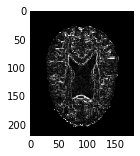

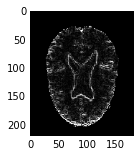

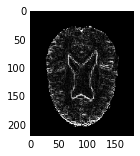

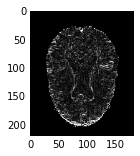

In [63]:
myshow(fa_distance_image)
myshow(md_distance_image)
myshow(rd_distance_image)
myshow(ad_distance_image)

In [64]:
fa_distance_image_fn = os.path.join(output_dir,sr_name + '_FA_distance.nrrd')
md_distance_image_fn = os.path.join(output_dir,sr_name + '_MD_distance.nrrd')
rd_distance_image_fn = os.path.join(output_dir,sr_name + '_RD_distance.nrrd')
ad_distance_image_fn = os.path.join(output_dir,sr_name + '_AD_distance.nrrd')
# frobenius_distance_image_fn = os.path.join(output_dir,sr_name + '_Frobenius_distance.nrrd')
# logeuclid_distance_image_fn = os.path.join(output_dir,sr_name + '_Logeuclid_distance.nrrd')
# reimann_distance_image_fn = os.path.join(output_dir,sr_name + '_Reimann_distance.nrrd')
# kullback_distance_image_fn = os.path.join(output_dir,sr_name + '_Kullback_distance.nrrd')

In [65]:
## Write out the distance images
sitk.WriteImage(fa_distance_image,fa_distance_image_fn)
sitk.WriteImage(md_distance_image,md_distance_image_fn)
sitk.WriteImage(rd_distance_image,rd_distance_image_fn)
sitk.WriteImage(ad_distance_image,ad_distance_image_fn)
# sitk.WriteImage(frobenius_distance_image,frobenius_distance_image_fn)
# sitk.WriteImage(logeuclid_distance_image,logeuclid_distance_image_fn)
# sitk.WriteImage(reimann_distance_image,reimann_distance_image_fn)
# sitk.WriteImage(kullback_distance_image,kullback_distance_image_fn)

In [67]:
# # Do sum tests
# statFilter = sitk.StatisticsImageFilter()
# print('-----AD-------')
# statFilter.Execute(fa_distance_image)
# print(statFilter.GetMaximum())
# print(statFilter.GetMinimum())
# print(statFilter.GetMean())
# print('-----MD-------')
# statFilter.Execute(md_distance_image)
# print(statFilter.GetMaximum())
# print(statFilter.GetMinimum())
# print(statFilter.GetMean())
# print('-----RD-------')
# statFilter.Execute(rd_distance_image)
# print(statFilter.GetMaximum())
# print(statFilter.GetMinimum())
# print(statFilter.GetMean())
# print('-----AD-------')
# statFilter.Execute(ad_distance_image)
# print(statFilter.GetMaximum())
# print(statFilter.GetMinimum())
# print(statFilter.GetMean())

# ## NN_base images (using outlier of %95)
# print('===================================')
# fa_fn = '/scratch/TESTS/IpythonNotebook/20160615_HCPWF/mainWF/NN_dist_images/NN_FA_distance.nrrd'
# md_fn = '/scratch/TESTS/IpythonNotebook/20160615_HCPWF/mainWF/NN_dist_images/NN_MD_distance.nrrd'
# rd_fn = '/scratch/TESTS/IpythonNotebook/20160615_HCPWF/mainWF/NN_dist_images/NN_RD_distance.nrrd'
# ad_fn = '/scratch/TESTS/IpythonNotebook/20160615_HCPWF/mainWF/NN_dist_images/NN_AD_distance.nrrd'
# fa = sitk.ReadImage(fa_fn)
# md = sitk.ReadImage(md_fn)
# rd = sitk.ReadImage(rd_fn)
# ad = sitk.ReadImage(ad_fn)
# print('-----AD-------')
# statFilter.Execute(fa)
# print(statFilter.GetMaximum())
# print(statFilter.GetMinimum())
# print(statFilter.GetMean())
# print('-----MD-------')
# statFilter.Execute(md)
# print(statFilter.GetMaximum())
# print(statFilter.GetMinimum())
# print(statFilter.GetMean())
# print('-----RD-------')
# statFilter.Execute(rd)
# print(statFilter.GetMaximum())
# print(statFilter.GetMinimum())
# print(statFilter.GetMean())
# print('-----AD-------')
# statFilter.Execute(ad)
# print(statFilter.GetMaximum())
# print(statFilter.GetMinimum())
# print(statFilter.GetMean())

In [73]:
### NOW work on tensor error images

In [221]:
print(tenfit_base.quadratic_form.shape)
print(tenfit_sr.quadratic_form.shape)

(145, 174, 145, 3, 3)
(145, 174, 145, 3, 3)


In [222]:
test_tenfit_base = tenfit_base.quadratic_form[65:80,80:95,65:80]
test_tenfit_sr = tenfit_sr.quadratic_form[65:80,80:95,65:80]
print(test_tenfit_base.shape)
print(test_tenfit_sr.shape)

(15, 15, 15, 3, 3)
(15, 15, 15, 3, 3)


In [223]:
from scipy.linalg import logm
from scipy.linalg import eigvalsh # eigvalsh(A,B) is joint eigenvalues of A and B
#########
### distance functions ###
# Frobenius distance
def distance_euclid(A, B):
    return np.linalg.norm(A - B, ord='fro')
# Log-Euclidian distance
def distance_logeuclid(A, B):
    return distance_euclid(logm(A),logm(B))
# Reimannian distance
def distance_reimann(A, B):
    return np.sqrt((np.log(eigvalsh(A,B))**2).sum())
# Kullback-Leibler distance
def distance_kullback(A, B):
    dim = A.shape[0]
    kl = np.sqrt( np.trace( np.dot(np.linalg.inv(A),B)+np.dot(np.linalg.inv(B),A) ) - 2*dim )
    return 0.5*kl
######### 

In [224]:
size = [test_tenfit_base.shape[0],test_tenfit_base.shape[1],test_tenfit_base.shape[2]]
print(size)
frobenius_distance_arr = np.empty(size, dtype=float)
logeuclid_distance_arr = np.empty(size, dtype=float)
reimann_distance_arr = np.empty(size, dtype=float)
kullback_distance_arr = np.empty(size, dtype=float)

[15, 15, 15]


In [225]:
from itertools import product
import time

In [252]:
t = time.time()
for i, idx in enumerate(product(xrange(size[0]),xrange(size[1]),xrange(size[2]))):
    #frobenius_distance_arr[idx] = distance_euclid(test_tenfit_base[idx], test_tenfit_sr[idx])
    #logeuclid_distance_arr[idx] = distance_logeuclid(test_tenfit_base[idx], test_tenfit_sr[idx])
    reimann_distance_arr[idx] = distance_reimann(test_tenfit_base[idx], test_tenfit_sr[idx])
    #kullback_distance_arr[idx] = distance_kullback(test_tenfit_base[idx], test_tenfit_sr[idx])
elapsed = time.time() - t
print('for loop took: ', elapsed)

for loop took:  0.656296014786


In [227]:
t = time.time()
for i in xrange(size[0]):
        for j in xrange(size[1]):
            for k in xrange(size[2]):
                frobenius_distance_arr[i,j,k] = distance_euclid(test_tenfit_base[i,j,k], test_tenfit_sr[i,j,k])
                #logeuclid_distance_arr[i,j,k] = distance_logeuclid(test_tenfit_base[i,j,k], test_tenfit_sr[i,j,k])
                reimann_distance_arr[i,j,k] = distance_reimann(test_tenfit_base[i,j,k], test_tenfit_sr[i,j,k])
                kullback_distance_arr[i,j,k] = distance_kullback(test_tenfit_base[i,j,k], test_tenfit_sr[i,j,k])
elapsed = time.time() - t
print('for loop took: ', elapsed)

for loop took:  0.744137048721


In [228]:
t = time.time()
frobenius_distance_list = [distance_euclid(test_tenfit_base[idx], test_tenfit_sr[idx]) 
                           for i, idx in enumerate(product(xrange(size[0]),xrange(size[1]),xrange(size[2])))]
#logeuclid_distance_list = [distance_logeuclid(test_tenfit_base[idx], test_tenfit_sr[idx]) 
#                           for i, idx in enumerate(product(xrange(size[0]),xrange(size[1]),xrange(size[2])))]
reimann_distance_list = [distance_reimann(test_tenfit_base[idx], test_tenfit_sr[idx]) 
                         for i, idx in enumerate(product(xrange(size[0]),xrange(size[1]),xrange(size[2])))]
kullback_distance_list = [distance_kullback(test_tenfit_base[idx], test_tenfit_sr[idx]) 
                          for i, idx in enumerate(product(xrange(size[0]),xrange(size[1]),xrange(size[2])))]
#
frobenius_distance_arr = np.array(frobenius_distance_list).reshape(size)
logeuclid_distance_arr = np.array(logeuclid_distance_list).reshape(size)
reimann_distance_arr = np.array(reimann_distance_list).reshape(size)
kullback_distance_arr = np.array(kullback_distance_list).reshape(size)
elapsed = time.time() - t
print('for loop took: ', elapsed)

for loop took:  0.66806602478


In [246]:
logeuclid_distance_arr = np.empty(size, dtype=float)
logeuclid_distance_arr.fill(0)

In [249]:
#print(logeuclid_distance_arr)
print(np.min(logeuclid_distance_arr))

0.0


In [93]:
v_eunclid = np.vectorize(distance_euclid, excluded={4,5})

In [94]:
out = v_eunclid(tenfit_base.quadratic_form,tenfit_sr.quadratic_form)

ValueError: Improper number of dimensions to norm.